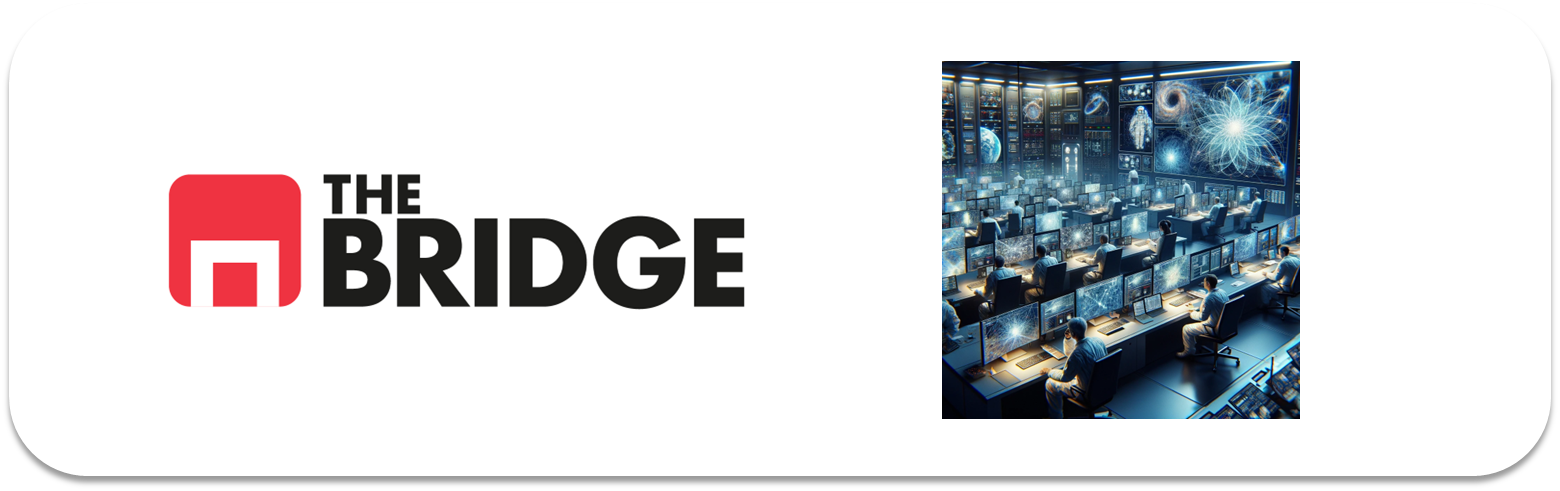

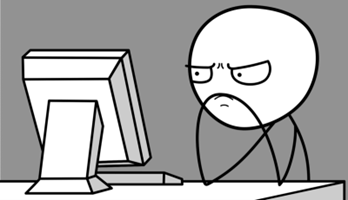

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model, layers, models, optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import pandas as pd
import random
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [2]:
TRAIN_PATH = './data/apples/Train'
TEST_PATH = './data/apples/Test'

In [3]:
# Inicializar listas
X_train, y_train = [], []
X_test, y_test = [], []
X_test_224, y_test_224 = [], []

# TRAIN 32x32
for category in os.listdir(TRAIN_PATH):
    folder = os.path.join(TRAIN_PATH, category)
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convertir a RGB
        img_resized = cv2.resize(img, (32, 32))
        X_train.append(img_resized)
        y_train.append(category)

# TEST 32x32
for category in os.listdir(TEST_PATH):
    folder = os.path.join(TEST_PATH, category)
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (32, 32))
        X_test.append(img_resized)
        y_test.append(category)

# TEST 224x224
for category in os.listdir(TEST_PATH):
    folder = os.path.join(TEST_PATH, category)
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (224, 224))
        X_test_224.append(img_resized)
        y_test_224.append(category)

# Transformar a numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

# Revisar shapes
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test:", X_test.shape, "| y_test:", y_test.shape)
print("X_test_224:", X_test_224.shape, "| y_test_224:", y_test_224.shape)

X_train: (6404, 32, 32, 3) | y_train: (6404,)
X_test: (2134, 32, 32, 3) | y_test: (2134,)
X_test_224: (2134, 224, 224, 3) | y_test_224: (2134,)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

In [4]:
def mostrar_imagenes_batch(imagenes, etiquetas, n_cols=5, size_scale=2):
    """
    Muestra un batch de imágenes con sus etiquetas.
    
    Args:
    - imagenes (np.array): Array de imágenes.
    - etiquetas (np.array/list): Array/lista de etiquetas (textuales).
    - n_cols (int): Número de columnas en la cuadrícula.
    - size_scale (int): Escala de tamaño de la figura.
    """
    n_images = len(imagenes)
def mostrar_imagenes_batch(imagenes, etiquetas, n_cols=5, size_scale=2):
    """
    Muestra un batch de imágenes con sus etiquetas.
    
    Args:
    - imagenes (np.array): Array de imágenes.
    - etiquetas (np.array/list): Array/lista de etiquetas (textuales).
    - n_cols (int): Número de columnas en la cuadrícula.
    - size_scale (int): Escala de tamaño de la figura.
    """
    n_images = len(imagenes)
    n_rows = (n_images - 1) // n_cols + 1

    plt.figure(figsize=(n_cols * size_scale, n_rows * size_scale))
    
    for idx, img in enumerate(imagenes):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.title(etiquetas[idx], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

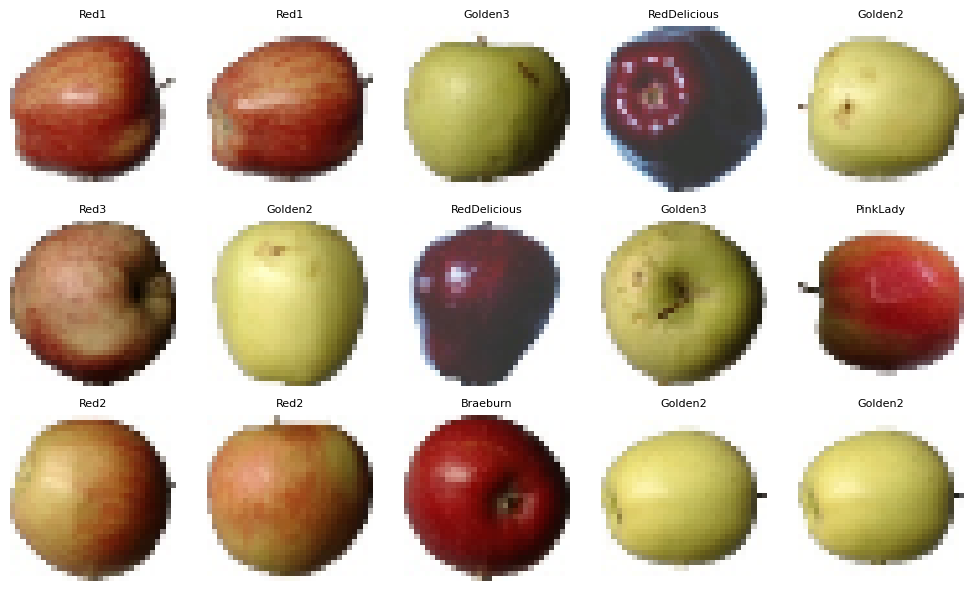

In [5]:
indices = np.random.choice(len(X_train), 15, replace=False)
mostrar_imagenes_batch(X_train[indices], y_train[indices])

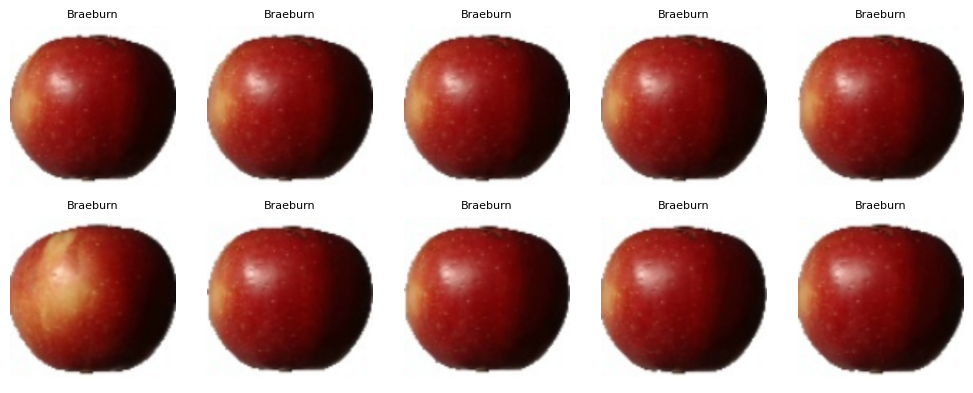

In [6]:
mostrar_imagenes_batch(X_test_224[10:20], y_test_224[10:20])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

In [7]:
print("Número de imágenes en train:", len(X_train))
print("Número de imágenes en test:", len(X_test))

categorias_unicas = np.unique(y_train)
n_categorias = len(categorias_unicas)
print("Número de clases:", n_categorias)
print("Clases:", categorias_unicas)

Número de imágenes en train: 6404
Número de imágenes en test: 2134
Número de clases: 13
Clases: ['Braeburn' 'CrimsonSnow' 'Golden1' 'Golden2' 'Golden3' 'GrannySmith'
 'PinkLady' 'Red1' 'Red2' 'Red3' 'RedDelicious' 'RedYellow1' 'RedYellow2']


In [8]:
train_counts = pd.Series(y_train).value_counts()
train_proportion = pd.Series(y_train).value_counts(normalize=True)

print("Conteo por clase (train):\n", train_counts)
print("\nProporción por clase (train):\n", train_proportion)

Conteo por clase (train):
 RedYellow2      672
Braeburn        492
Golden2         492
GrannySmith     492
Red1            492
Red2            492
RedYellow1      492
RedDelicious    490
Golden3         481
Golden1         480
PinkLady        456
CrimsonSnow     444
Red3            429
Name: count, dtype: int64

Proporción por clase (train):
 RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64


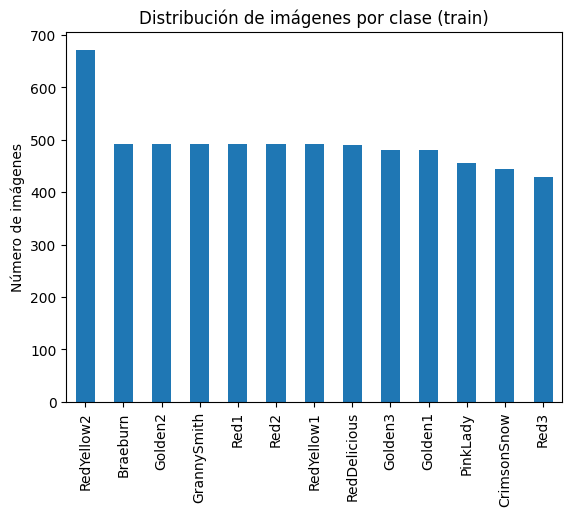

In [9]:
train_counts.plot(kind='bar', title='Distribución de imágenes por clase (train)')
plt.ylabel('Número de imágenes')
plt.show()

In [10]:
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape X_test_224:", X_test_224.shape)

Shape X_train: (6404, 32, 32, 3)
Shape X_test: (2134, 32, 32, 3)
Shape X_test_224: (2134, 224, 224, 3)


**Accuracy es la métrica principal, porque es clasificación multiclase balanceada.**

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [11]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [12]:
X_train_s, y_train_s = shuffle(X_train_scaled, y_train, random_state=42)

In [13]:
categorias = np.unique(y_train_s)
mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {i: cat for cat, i in mapping.items()}

y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [14]:
categorias = np.unique(y_train_s)
print("Categorías únicas:", categorias)

Categorías únicas: ['Braeburn' 'CrimsonSnow' 'Golden1' 'Golden2' 'Golden3' 'GrannySmith'
 'PinkLady' 'Red1' 'Red2' 'Red3' 'RedDelicious' 'RedYellow1' 'RedYellow2']


In [15]:
# Etiqueta a número
mapping = {cat: i for i, cat in enumerate(categorias)}

# Número a etiqueta
inverse_mapping = {i: cat for cat, i in mapping.items()}

print("Mapping (etiqueta → número):", mapping)
print("Inverse mapping (número → etiqueta):", inverse_mapping)

Mapping (etiqueta → número): {np.str_('Braeburn'): 0, np.str_('CrimsonSnow'): 1, np.str_('Golden1'): 2, np.str_('Golden2'): 3, np.str_('Golden3'): 4, np.str_('GrannySmith'): 5, np.str_('PinkLady'): 6, np.str_('Red1'): 7, np.str_('Red2'): 8, np.str_('Red3'): 9, np.str_('RedDelicious'): 10, np.str_('RedYellow1'): 11, np.str_('RedYellow2'): 12}
Inverse mapping (número → etiqueta): {0: np.str_('Braeburn'), 1: np.str_('CrimsonSnow'), 2: np.str_('Golden1'), 3: np.str_('Golden2'), 4: np.str_('Golden3'), 5: np.str_('GrannySmith'), 6: np.str_('PinkLady'), 7: np.str_('Red1'), 8: np.str_('Red2'), 9: np.str_('Red3'), 10: np.str_('RedDelicious'), 11: np.str_('RedYellow1'), 12: np.str_('RedYellow2')}


In [16]:
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [17]:
base_model = ResNet50V2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [18]:
indices_random = np.random.randint(0, len(X_test_224), 10)
imagenes_random = X_test_224[indices_random]
etiquetas_reales = y_test_224[indices_random]

In [19]:
predicciones = base_model.predict(preprocess_input(imagenes_random))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [20]:
clases_predichas = [decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0][1] 
                    for pred in predicciones]

In [21]:
for i in range(len(imagenes_random)):
    print(f"Imagen {i}: Real = {etiquetas_reales[i]} | Predicho = {clases_predichas[i]}")

Imagen 0: Real = RedDelicious | Predicho = trifle
Imagen 1: Real = CrimsonSnow | Predicho = English_foxhound
Imagen 2: Real = Braeburn | Predicho = trifle
Imagen 3: Real = Golden2 | Predicho = bow_tie
Imagen 4: Real = PinkLady | Predicho = fox_squirrel
Imagen 5: Real = GrannySmith | Predicho = fox_squirrel
Imagen 6: Real = RedYellow1 | Predicho = trifle
Imagen 7: Real = Red1 | Predicho = trifle
Imagen 8: Real = GrannySmith | Predicho = fox_squirrel
Imagen 9: Real = Golden2 | Predicho = English_foxhound


**El modelo ResNet50V2 devuelve etiquetas genéricas de ImageNet, como 'Granny_Smith', 'pomegranate' o incluso cosas absurdas como 'ping-pong ball'. Aunque puede acertar alguna variedad (como Granny Smith), no distingue bien entre nuestras 13 clases de manzana, por lo que no sirve como clasificador directo. Necesitamos hacer transfer learning o fine-tuning para adaptarlo a nuestras clases específicas.**

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [28]:
# Cargar modelo base
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Añadir cabeza personalizada
x = layers.Flatten()(base_model.output)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(13, activation='softmax')(x)

# Crear modelo completo
model = Model(inputs=base_model.input, outputs=output)

# Compilar
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 91s 738ms/step - accuracy: 0.4932 - loss: 1.8539 - val_accuracy: 0.9313 - val_loss: 0.2684
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9157 - loss: 0.3063 - val_accuracy: 0.9797 - val_loss: 0.1143
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 514ms/step - accuracy: 0.9541 - loss: 0.1715 - val_accuracy: 0.9906 - val_loss: 0.0613
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 88s 589ms/step - accuracy: 0.9806 - loss: 0.0935 - val_accuracy: 0.9945 - val_loss: 0.0428
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 401ms/step - accuracy: 0.9653 - loss: 0.1123 - val_accuracy: 0.9992 - val_loss: 0.0266
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 53s 540ms/step - accuracy: 0.9866 - loss: 0.0601 - val_accuracy: 0.9992 - val_loss: 0.0185
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 558ms/step - accuracy: 0.9929 - loss: 0.0405 - val_accuracy: 0.9992 - val_loss: 0.0154
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 84s 574ms/step - accuracy: 0.9616 - loss: 0.1196 - val_accu

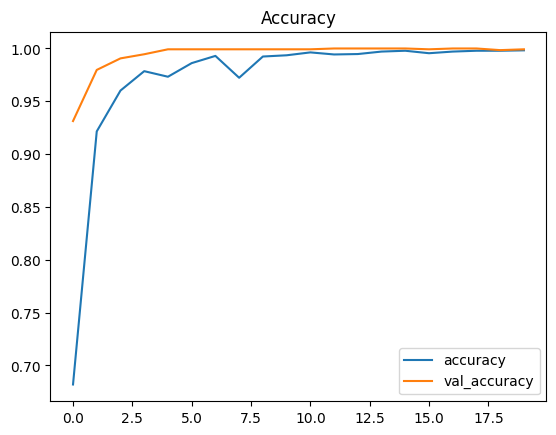

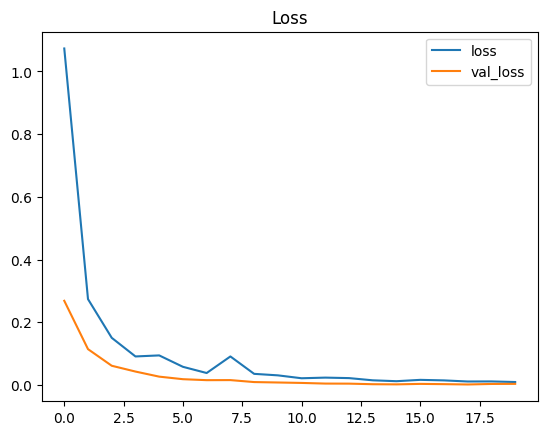

In [30]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

batch_size = 64

history = model.fit(
    X_train_s,
    y_train_num,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=20,
    callbacks=[early_stop]
)

evol = pd.DataFrame(history.history)
evol[['accuracy', 'val_accuracy']].plot(title='Accuracy')
plt.show()
evol[['loss', 'val_loss']].plot(title='Loss')
plt.show()

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step
Classification Report:

              precision    recall  f1-score   support

    Braeburn       0.00      0.00      0.00       164
 CrimsonSnow       0.00      0.00      0.00       148
     Golden1       0.00      0.00      0.00       160
     Golden2       0.00      0.00      0.00       164
     Golden3       0.00      0.00      0.00       161
 GrannySmith       0.00      0.00      0.00       164
    PinkLady       0.00      0.00      0.00       152
        Red1       0.00      0.00      0.00       164
        Red2       0.00      0.00      0.00       164
        Red3       0.00      0.00      0.00       144
RedDelicious       0.15      0.30      0.20       166
  RedYellow1       0.00      0.00      0.00       164
  RedYellow2       0.05      0.39      0.08       219

    accuracy                           0.06      2134
   macro avg       0.02      0.05      0.02      2134
weighted avg       0.02      0.06      0.02      2134



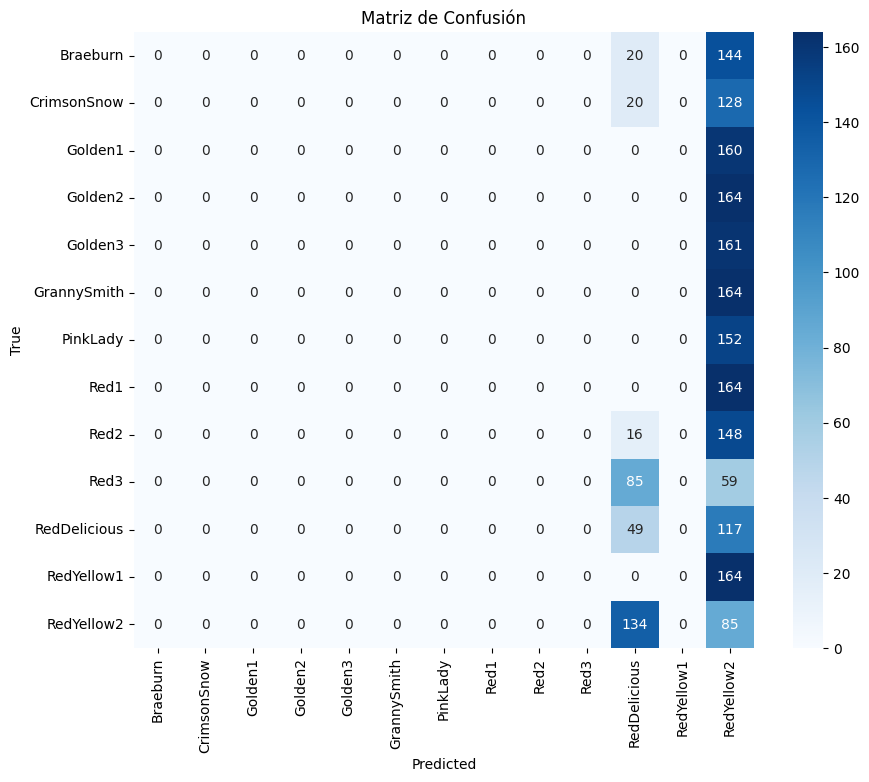

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test_num, y_pred, target_names=categorias))

# Matriz de confusión
cm = confusion_matrix(y_test_num, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categorias, yticklabels=categorias)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [32]:
base_model = ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3))

In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(300, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(13, activation='softmax')(x)  # 13 clases

In [35]:
model_ft = Model(inputs=base_model.input, outputs=output)

In [36]:
model_ft.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [37]:
model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,183,413 (92.25 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 276ms/step - accuracy: 0.1060 - loss: 2.5543 - val_accuracy: 0.1265 - val_loss: 2.4908
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.1723 - loss: 2.4699 - val_accuracy: 0.2709 - val_loss: 2.3434
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.2628 - loss: 2.2970 - val_accuracy: 0.3185 - val_loss: 2.1231
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.3142 - loss: 2.0914 - val_accuracy: 0.3989 - val_loss: 1.9210
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - accuracy: 0.3538 - loss: 1.9077 - val_accuracy: 0.5215 - val_loss: 1.7857
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.4027 - loss: 1.7799 - val_accuracy: 0.5012 - val_loss: 1.6362
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.4442 - loss: 1.6601 - val_accuracy: 0.5371 - val_loss: 1.5317
Epoch 8/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.4642 - loss: 1.5815 - val_accu

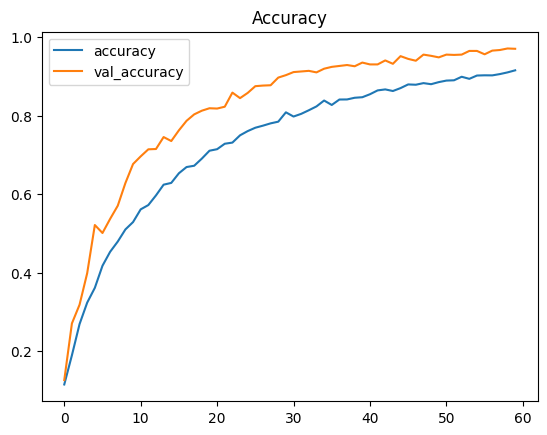

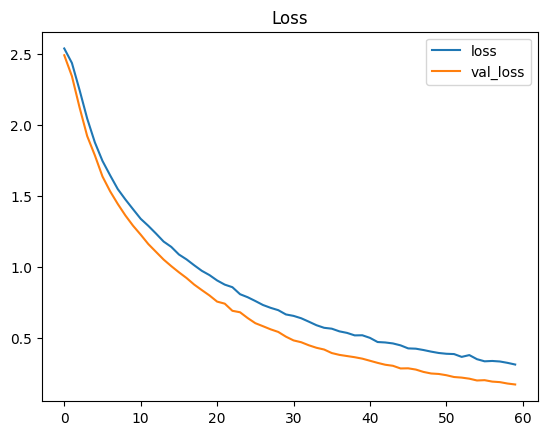

In [38]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model_ft.fit(
    X_train_s,
    y_train_num,
    batch_size=64,
    validation_split=0.2,
    epochs=60,
    callbacks=[early_stop]
)

evol = pd.DataFrame(history.history)
evol[['accuracy', 'val_accuracy']].plot(title='Accuracy')
plt.show()
evol[['loss', 'val_loss']].plot(title='Loss')
plt.show()

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step
Classification Report (Fine Tuning desde cero):

              precision    recall  f1-score   support

    Braeburn       0.75      0.79      0.77       164
 CrimsonSnow       1.00      0.65      0.79       148
     Golden1       0.81      0.69      0.74       160
     Golden2       0.78      1.00      0.88       164
     Golden3       0.97      0.48      0.64       161
 GrannySmith       0.72      0.99      0.84       164
    PinkLady       0.89      1.00      0.94       152
        Red1       0.71      0.93      0.80       164
        Red2       0.86      0.71      0.78       164
        Red3       1.00      0.84      0.91       144
RedDelicious       0.96      1.00      0.98       166
  RedYellow1       0.91      1.00      0.95       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.86      2134
   macro avg       0.87      0.85      0.85      2134
weighted avg       0.88      0.86      0.85

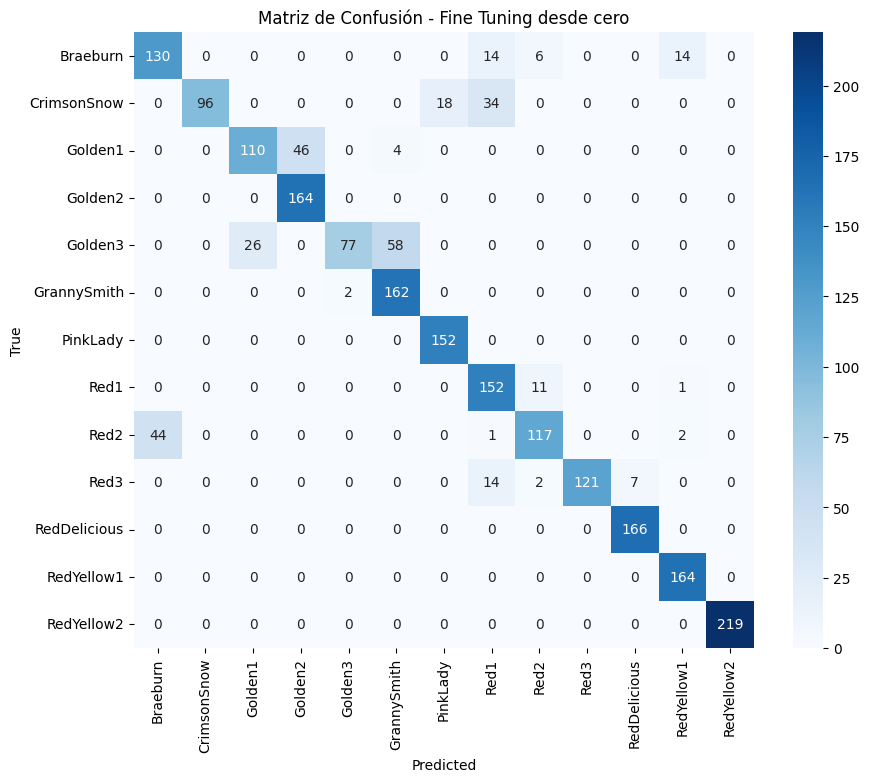

In [39]:
# Predicciones fine tuning desde cero
y_pred_probs_ft = model_ft.predict(X_test)
y_pred_ft = np.argmax(y_pred_probs_ft, axis=1)

# Reporte
print("Classification Report (Fine Tuning desde cero):\n")
print(classification_report(y_test_num, y_pred_ft, target_names=categorias))

# Matriz de confusión
cm_ft = confusion_matrix(y_test_num, y_pred_ft)
plt.figure(figsize=(10,8))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=categorias, yticklabels=categorias)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - Fine Tuning desde cero')
plt.show()